# Lecture 05. Where Logistic Regression Is Good and Where It's Not

### Analysis of IMDB movie reviews

Now for a little practice! We want to solve the problem of binary classification of IMDB movie reviews. We have a training set with marked reviews, 12500 reviews marked as good, another 12500 bad. Here, it's not easy to get started with machine learning right away because we don't have the matrix $X$; we need to prepare it. We will use a simple approach: bag of words model. Features of the review will be represented by indicators of the presence of each word from the whole corpus in this review. The corpus is the set of all user reviews. The idea is illustrated by a picture

<img src="../../img/bag_of_words.svg" width=80% />

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

**To get started, we automatically download the dataset from [here](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) and unarchive it along with the rest of datasets in the data folder. The dataset is briefly described [here](http://ai.stanford.edu/~amaas/data/sentiment/). There are 12.5k of good and bad reviews in the test and training sets.**

In [4]:
from io import BytesIO
import requests
import tarfile

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

def load_imdb_dataset(extract_path="../../data", overwrite=False):
    #check if existed already
    if os.path.isfile(os.path.join(extract_path, "aclImdb", "README")) and not overwrite:
        print("IMDB dataset is already in place.")
        return
    
    print("Downloading the dataset from:  ", url)
    response = requests.get(url)
    
    tar = tarfile.open(mode= "r:gz", fileobj = BytesIO(response.content))
    
    data = tar.extractall(extract_path)
    
load_imdb_dataset()

IMDB dataset is already in place.


In [5]:
#change if you have it in alternative location
PATH_TO_IMDB = "../../data/aclImdb"

reviews_train = load_files(os.path.join(PATH_TO_IMDB, "train"),
                           categories=['pos', 'neg'])
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"),
                          categories=['pos', 'neg'])
text_test, y_test = reviews_test.data, reviews_test.target

In [6]:
# # Alternatively, load data from previously pickled objects. 
# import pickle
# with open('../../data/imdb_text_train.pkl', 'rb') as f:
#     text_train = pickle.load(f)
# with open('../../data/imdb_text_test.pkl', 'rb') as f:
#     text_test = pickle.load(f)
# with open('../../data/imdb_target_train.pkl', 'rb') as f:
#     y_train = pickle.load(f)
# with open('../../data/imdb_target_test.pkl', 'rb') as f:
#     y_test = pickle.load(f)

In [7]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in training data: 25000
[12500 12500]
Number of documents in test data: 25000
[12500 12500]


**Here are a few examples of the reviews.**

In [8]:
print(text_train[1])

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [9]:
y_train[1] # bad review

0

In [10]:
text_train[2]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [11]:
y_train[2] # good review

1

In [12]:
# import pickle
# with open('../../data/imdb_text_train.pkl', 'wb') as f:
#     pickle.dump(text_train, f)
# with open('../../data/imdb_text_test.pkl', 'wb') as f:
#     pickle.dump(text_test, f)
# with open('../../data/imdb_target_train.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# with open('../../data/imdb_target_test.pkl', 'wb') as f:
#     pickle.dump(y_test, f)

## A Simple Count of Words

**First, we will create a dictionary of all the words using CountVectorizer**

In [13]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

**If you look at the examples of "words" (let's call them tokens), you can see that we have omitted many of the important steps in text processing (automatic text processing can itself be a completely separate series of articles).**

In [14]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


**Secondly, we are encoding the sentences from the training set texts with the indices of incoming words. We'll use the sparse format.**

In [15]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

**Let's see how our transformation worked**

In [16]:
print(text_train[19726])


b'This movie is terrible but it has some good effects.'


In [17]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562], dtype=int32)

In [18]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562], dtype=int32))

**Third, we will apply the same operations to the test set**

In [19]:
X_test = cv.transform(text_test)

**The next step is to train Logistic Regression.**

In [ ]:
%%time
logit = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

In [55]:
t = cv.transform(["When will these dimwitted Right wing zealots learn that maybe it's not such a great idea to throw your career and reputation away for a dimwitted, selfish, wannabe dictator?"])
print(logit.predict_proba(t[0]))
t = cv.transform(['perfect movie'])
print(logit.predict_proba(t[0]))

[[0.70564423 0.29435577]]
[[0.22673285 0.77326715]]


**Let's look at accuracy on the both the training and the test sets.**

In [21]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3),

(0.981, 0.864)

**The coefficients of the model can be beautifully displayed.**

In [22]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");


In [23]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();
    

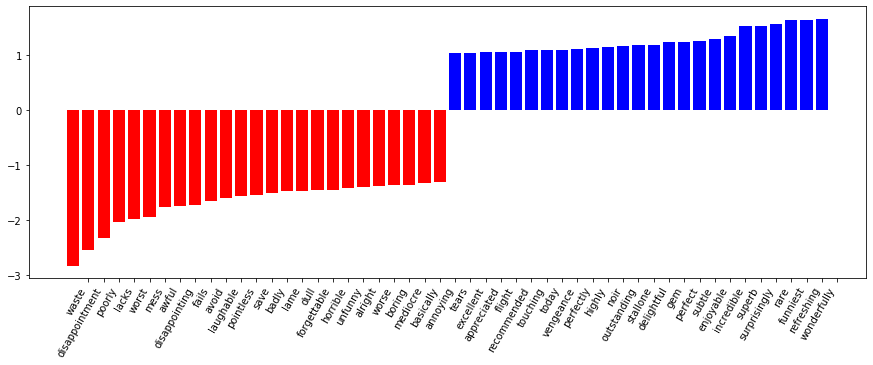

In [24]:
visualize_coefficients(logit, cv.get_feature_names())

**To make our model better, we can optimize the regularization coefficient for the `Logistic Regression`. We'll use `sklearn.pipeline` because `CountVectorizer` should only be applied to the training data (so as to not "peek" into the test set and not count word frequencies there). In this case, `pipeline` determines the correct sequence of actions: apply `CountVectorizer`, then train `Logistic Regression`.**

In [25]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(),
                                # for some reason n_jobs > 1 won't work 
                                # with GridSearchCV's n_jobs > 1
                                LogisticRegression(solver='lbfgs', 
                                                   n_jobs=1,
                                                   random_state=7))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.8642
CPU times: user 17.2 s, sys: 5.8 s, total: 23 s
Wall time: 15.1 s


In [26]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, 
                          param_grid_logit, 
                          return_train_score=True, 
                          cv=3, n_jobs=-1)

grid_logit.fit(text_train, y_train)

CPU times: user 18.4 s, sys: 7.69 s, total: 26.1 s
Wall time: 4min 41s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('countvectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                 

**Let's print best $C$ and cv-score using this hyperparameter:**

In [27]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.88484)

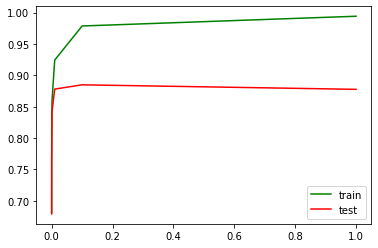

In [28]:
plot_grid_scores(grid_logit, 'logisticregression__C')

For the validation set:

In [29]:
grid_logit.score(text_test, y_test)

0.87812

**Now let's do the same with random forest. We see that, with logistic regression, we achieve better accuracy with less effort.**

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
forest = RandomForestClassifier(n_estimators=200, 
                                n_jobs=-1, random_state=17)

In [32]:
%%time
forest.fit(X_train, y_train)

CPU times: user 4min 20s, sys: 1.48 s, total: 4min 22s
Wall time: 1min 13s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [33]:
round(forest.score(X_test, y_test), 3)

0.855

### XOR-Problem
Let's now consider an example where linear models are worse.

Linear classification methods still define a very simple separating surface - a hyperplane. The most famous toy example of where classes cannot be divided by a hyperplane (or line) with no errors is "the XOR problem".

XOR is the "exclusive OR", a Boolean function with the following truth table:



<img src='../../img/XOR_table.gif'>

XOR is the name given to a simple binary classification problem in which the classes are presented as diagonally extended intersecting point clouds.

In [34]:
# creating dataset
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

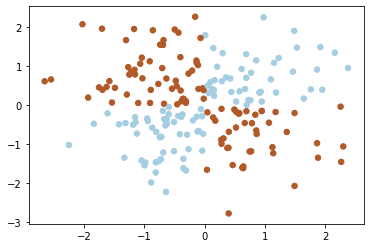

In [35]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

Obviously, one cannot draw a single straight line to separate one class from another without errors. Therefore, logistic regression performs poorly with this task.

In [36]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'linetypes'
  del sys.path[0]


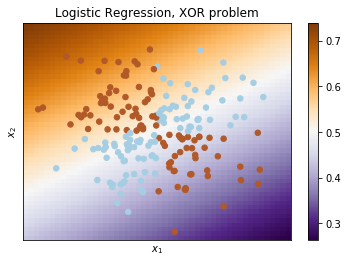

In [37]:
plot_boundary(LogisticRegression(solver='lbfgs'), X, y,
              "Logistic Regression, XOR problem")

But if one were to give polynomial features as an input (here, up to 2 degrees), then the problem is solved.

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [39]:
logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', LogisticRegression(solver='lbfgs' ))])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'linetypes'
  del sys.path[0]


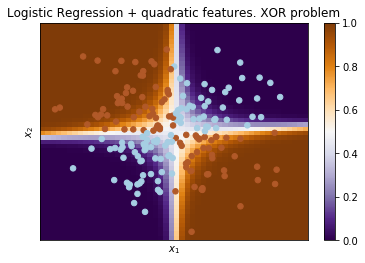

In [40]:
plot_boundary(logit_pipe, X, y,
              "Logistic Regression + quadratic features. XOR problem")

Here, logistic regression has still produced a hyperplane but in a 6-dimensional feature space $1, x_1, x_2, x_1^2, x_1x_2$ and $x_2^2$. When we project to the original feature space, $x_1, x_2$, the boundary is nonlinear.

In practice, polynomial features do help, but it is computationally inefficient to build them explicitly. SVM with the kernel trick works much faster. In this approach, only the distance between the objects (defined by the kernel function) in a high dimensional space is computed, and there is no need to produce a combinatorially large number of features. 

### Useful resources
- Main course [site](https://mlcourse.ai), [course repo](https://github.com/Yorko/mlcourse.ai), and YouTube [channel](https://www.youtube.com/watch?v=QKTuw4PNOsU&list=PLVlY_7IJCMJeRfZ68eVfEcu-UcN9BbwiX)
- Medium ["story"](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-4-linear-classification-and-regression-44a41b9b5220) based on this notebook
- Course materials as a [Kaggle Dataset](https://www.kaggle.com/kashnitsky/mlcourse)
- If you read Russian: an [article](https://habrahabr.ru/company/ods/blog/323890/) on Habrahabr with ~ the same material. And a [lecture](https://youtu.be/oTXGQ-_oqvI) on YouTube
- A nice and concise overview of linear models is given in the book [“Deep Learning”](http://www.deeplearningbook.org) (I. Goodfellow, Y. Bengio, and A. Courville).
- Linear models are covered practically in every ML book. We recommend “Pattern Recognition and Machine Learning” (C. Bishop) and “Machine Learning: A Probabilistic Perspective” (K. Murphy).
- If you prefer a thorough overview of linear model from a statistician’s viewpoint, then look at “The elements of statistical learning” (T. Hastie, R. Tibshirani, and J. Friedman).
- The book “Machine Learning in Action” (P. Harrington) will walk you through implementations of classic ML algorithms in pure Python.
- [Scikit-learn](http://scikit-learn.org/stable/documentation.html) library. These guys work hard on writing really clear documentation.
- Scipy 2017 [scikit-learn tutorial](https://github.com/amueller/scipy-2017-sklearn) by Alex Gramfort and Andreas Mueller.
- One more [ML course](https://github.com/diefimov/MTH594_MachineLearning) with very good materials.
- [Implementations](https://github.com/rushter/MLAlgorithms) of many ML algorithms. Search for linear regression and logistic regression.

Author: [Yury Kashnitskiy](https://yorko.github.io). Translated and edited by [Christina Butsko](https://www.linkedin.com/in/christinabutsko/), [Nerses Bagiyan](https://www.linkedin.com/in/nersesbagiyan/), [Yulia Klimushina](https://www.linkedin.com/in/yuliya-klimushina-7168a9139), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.